In [2]:
import pandas as pd
rs2 = pd.read_csv('rs2.csv', encoding='latin-1')
display(rs2)


,sentence1,sentence2,score,lang1,lang2
0,Ein Flugzeug hebt gerade ab.,An air plane is taking off.,5.0,de,en
1,Ein Flugzeug hebt gerade ab.,Un aviÃ³n estÃ¡ despegando.,5.0,de,es
2,Ein Flugzeug hebt gerade ab.,Un avion est en train de dÃ©coller.,5.0,de,fr
3,Ein Flugzeug hebt gerade ab.,Un aereo sta decollando.,5.0,de,it
4,Ein Flugzeug hebt gerade ab.,é£è¡æ©ãé¢é¸ãã¾ãã,5.0,de,ja
...,...,...,...,...,...
949075,é©å½å®£å¸MERSç«æ ç»æ,åæé®®ã®ä»£è¡¨å£ãéå½æ¿åºé¢ä¿è ã...,0.0,zh,ja
949076,é©å½å®£å¸MERSç«æ ç»æ,Delegatie Noord-Korea Ontmoetingen met Zuid-Ko...,0.0,zh,nl
949077,é©å½å®£å¸MERSç«æ ç»æ,Delegacja Korei PÃ³Ånocnej spotyka siÄ z urz...,0.0,zh,pl
949078,é©å½å®£å¸MERSç«æ ç»æ,DelegaÃ§Ã£o da Coreia do Norte reÃºne-se com f...,0.0,zh,pt


We import libraries we are going to need


*   io= For handling input/output operations
*   re =For regular expressions

*   string =Provides common string operations
*   tqdm =For displaying progress bars in loops

*  np = For numerical operations (arrays, etc.)   

*   tf = for machine learning and deep learning models
*   layers = For building neural network layers






In [3]:
import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

We install the necessary libraries for translation, semantic embeddings, and machine learning evaluation.

In [1]:
pip install deep-translator sentence-transformers scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [4]:
from deep_translator import GoogleTranslator
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

we rename our dataset as "df"

In [5]:
df = pd.read_csv("rs2.csv")

We check for outliers in the score


In [6]:
Q1 = df['score'].quantile(0.25)
Q3 = df['score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['score'] < lower_bound) | (df['score'] > upper_bound)]

if not outliers.empty:
    print("Potential outliers in 'score' column:")
    display(outliers)


    df['score'] = np.clip(df['score'], lower_bound, upper_bound)
    print("\nDataFrame after outlier handling (capping):")
    display(df)
else:
    print("No potential outliers found in 'score' column.")

No potential outliers found in 'score' column.


As it is impossible to work with such a bid dataset on my computer I am going to work with a sample of it.

In [7]:
df_sample = df.sample(n=30, random_state=42)

We apply the technique of stemming. I used "clean_text" since it works with all the languages, not only with english

In [8]:
def clean_text(text):
    text = str(text).lower().strip()
    return text

# Aplies cleaness
df_sample['sentence1_clean'] = df_sample['sentence1'].apply(clean_text)
df_sample['sentence2_clean'] = df_sample['sentence2'].apply(clean_text)


print("DataFrame con frases limpias:")
display(df_sample)

DataFrame con frases limpias:


,sentence1,sentence2,score,lang1,lang2,sentence1_clean,sentence2_clean
842583,Мальчик и белая собака бегают по травянистым п...,Un garçon et un chien courant sur l'herbe,4.40,ru,fr,мальчик и белая собака бегают по травянистым п...,un garçon et un chien courant sur l'herbe
535932,Boston bombing suspect buried in Virginia,Le suspect d'une bombe à Boston enterré dans l...,5.00,en,fr,boston bombing suspect buried in virginia,le suspect d'une bombe à boston enterré dans l...
947342,Siria está de acuerdo en entregar las armas qu...,Cameron : la Syrie et la Russie doivent montre...,2.00,es,fr,siria está de acuerdo en entregar las armas qu...,cameron : la syrie et la russie doivent montre...
866785,"Ты просто должен основывать свой ответ на том,...",あなたはそれを望むかもしれませんが、与えられたプロセスは、あなたがその中で働かなければならな...,0.00,ru,ja,"ты просто должен основывать свой ответ на том,...",あなたはそれを望むかもしれませんが、与えられたプロセスは、あなたがその中で働かなければならな...
215268,一个滑板运动员在石壁上做着魔术。,Um skatista a subir até uma encosta.,2.20,zh,pt,一个滑板运动员在石壁上做着魔术。,um skatista a subir até uma encosta.
297871,新增捐款使美国今年对朝鲜的粮食援助总量达到10万吨。,"The donation of 60,000 tons brings the total o...",3.20,zh,en,新增捐款使美国今年对朝鲜的粮食援助总量达到10万吨。,"the donation of 60,000 tons brings the total o..."
712723,Je pense qu'il est encore possible de stocker ...,Non ho provato a conservare io stesso i semi d...,1.50,fr,it,je pense qu'il est encore possible de stocker ...,non ho provato a conservare io stesso i semi d...
211537,Zwei Wanderer stehen auf dem Gipfel eines schn...,Dois alpinistas estão no topo de uma montanha ...,3.40,de,pt,zwei wanderer stehen auf dem gipfel eines schn...,dois alpinistas estão no topo de uma montanha ...
652907,女性がジャガイモを切っています。,Uma mulher está a montar um cavalo.,0.75,ja,pt,女性がジャガイモを切っています。,uma mulher está a montar um cavalo.
684673,Deux chiens bruns se poursuivent dans la neige.,Due cani marroni stanno giocando tra loro nell...,4.20,fr,it,deux chiens bruns se poursuivent dans la neige.,due cani marroni stanno giocando tra loro nell...


As we can see, the new sentences (sentence1&2_clear) are in lowercase and in their rootform. By this way is easier to search for the similiarity

now we translate using GoogleTranslator and with retries and we store the results in new columns sentence1_en and sentence2_en.

In [10]:
import time

def translate_with_retry(text, retries=3):
    for _ in range(retries):
        try:
            translated = GoogleTranslator(source='auto', target='en').translate(text)
            if translated.lower().strip() != text.lower().strip():
                return translated
        except:
            pass
        time.sleep(1)
    return "[FAILED TRANSLATION] " + text
df_sample['sentence1_en'] = df_sample['sentence1_clean'].apply(translate_with_retry)
df_sample['sentence2_en'] = df_sample['sentence2_clean'].apply(translate_with_retry)
display(df_sample)

,sentence1,sentence2,score,lang1,lang2,sentence1_clean,sentence2_clean,sentence1_en,sentence2_en
842583,Мальчик и белая собака бегают по травянистым п...,Un garçon et un chien courant sur l'herbe,4.40,ru,fr,мальчик и белая собака бегают по травянистым п...,un garçon et un chien courant sur l'herbe,A boy and a white dog run through the grassy f...,A boy and a dog running on the grass
535932,Boston bombing suspect buried in Virginia,Le suspect d'une bombe à Boston enterré dans l...,5.00,en,fr,boston bombing suspect buried in virginia,le suspect d'une bombe à boston enterré dans l...,[FAILED TRANSLATION] boston bombing suspect bu...,The suspect of a boston bomb buried in the Vir...
947342,Siria está de acuerdo en entregar las armas qu...,Cameron : la Syrie et la Russie doivent montre...,2.00,es,fr,siria está de acuerdo en entregar las armas qu...,cameron : la syrie et la russie doivent montre...,Syria agrees to deliver chemical weapons,Cameron: Syria and Russia must show that the p...
866785,"Ты просто должен основывать свой ответ на том,...",あなたはそれを望むかもしれませんが、与えられたプロセスは、あなたがその中で働かなければならな...,0.00,ru,ja,"ты просто должен основывать свой ответ на том,...",あなたはそれを望むかもしれませんが、与えられたプロセスは、あなたがその中で働かなければならな...,You just have to base your answer to the fact ...,"You may want that, but the given process is so..."
215268,一个滑板运动员在石壁上做着魔术。,Um skatista a subir até uma encosta.,2.20,zh,pt,一个滑板运动员在石壁上做着魔术。,um skatista a subir até uma encosta.,A skateboarder is doing magic on a stone wall.,A skateboarder climbing to a slope.
297871,新增捐款使美国今年对朝鲜的粮食援助总量达到10万吨。,"The donation of 60,000 tons brings the total o...",3.20,zh,en,新增捐款使美国今年对朝鲜的粮食援助总量达到10万吨。,"the donation of 60,000 tons brings the total o...",The new donations have brought the total amoun...,"[FAILED TRANSLATION] the donation of 60,000 to..."
712723,Je pense qu'il est encore possible de stocker ...,Non ho provato a conservare io stesso i semi d...,1.50,fr,it,je pense qu'il est encore possible de stocker ...,non ho provato a conservare io stesso i semi d...,I think it is still possible to store seeds un...,"I did not try to keep tomato seeds myself, but..."
211537,Zwei Wanderer stehen auf dem Gipfel eines schn...,Dois alpinistas estão no topo de uma montanha ...,3.40,de,pt,zwei wanderer stehen auf dem gipfel eines schn...,dois alpinistas estão no topo de uma montanha ...,Two hikers are on the summit of a snow -covere...,Two climbers are at the top of a mountain look...
652907,女性がジャガイモを切っています。,Uma mulher está a montar um cavalo.,0.75,ja,pt,女性がジャガイモを切っています。,uma mulher está a montar um cavalo.,A woman is cutting potatoes.,A woman is setting up a horse.
684673,Deux chiens bruns se poursuivent dans la neige.,Due cani marroni stanno giocando tra loro nell...,4.20,fr,it,deux chiens bruns se poursuivent dans la neige.,due cani marroni stanno giocando tra loro nell...,Two brown dogs continue in the snow.,Two brown dogs are playing with each other in ...


Now we have all the data processed, we are going to pharaphrase to improve model robustness and in this case its important since Im using a small sample so this augments the dataset

with this command we install the Parrot library, which is used for generating English sentence paraphrases.

In [11]:
!pip install parrot


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00


In [12]:
!pip install --upgrade git+https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git

from parrot import Parrot

parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5")

  Cloning https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git to /tmp/pip-req-build-389j9vxr
  Running command git clone --filter=blob:none --quiet https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git /tmp/pip-req-build-389j9vxr
  Resolved https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git to commit 03084c54b64019ba5fa0b620b9c70ad81123e458
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.1 MB/s eta 0:00:00
  Created wheel for parrot: filename=parrot-1.0-py3-none-any.whl size=8590 sha256=f4c1218584f2fae03eed8ce2c08800b6dfa831ce27dba73d6eff5ad598d61f09
  Stored in directory: /tmp/pip-ephem-wheel-cache-w_abusa9/wheels/23/f7/3e/78a7e9cedb3f84bf924b01b2c5eaf51715d2bc3571bfda074b
Successfully built parrot
  Attempting uninstall: parrot
    Found existing installation: parrot 0.1.10
    Uninstalling parrot-0.1.10:
      Successfully

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
from parrot import Parrot
import torch
import pandas as pd

def get_paraphrase(sentence):
    try:
        paraphrases = parrot.augment(input_phrase=sentence)
        if paraphrases:
            return paraphrases[0][0]
        else:
            return sentence
    except:
        return sentence

df_sample['sentence1_paraphrased'] = df_sample['sentence1_en'].apply(get_paraphrase)
df_sample['sentence2_paraphrased'] = df_sample['sentence2_en'].apply(get_paraphrase)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Now we have our sentences tranlated we can use the sentence Transformer model to calculate similarity between the tw sentneces.
It is important to highlight that I didnt tokenize my sentences because this model already does it.

In [31]:
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer('sentence-transformers/LaBSE')

emb1 = model.encode(df_sample['sentence1_en'].tolist(), convert_to_tensor=True)
emb2 = model.encode(df_sample['sentence2_en'].tolist(), convert_to_tensor=True)
emb1_para = model.encode(df_sample['sentence1_paraphrased'].tolist(), convert_to_tensor=True)
emb2_para = model.encode(df_sample['sentence2_paraphrased'].tolist(), convert_to_tensor=True)

#calculate similarities
#origianal
sim_orig = util.cos_sim(emb1, emb2).diagonal()

# - original vs paraphrased
sim_1_vs_para = util.cos_sim(emb1, emb1_para).diagonal()

# - paraphrased
sim_para_vs_para = util.cos_sim(emb1_para, emb2_para).diagonal()

df_sample['similarity_original'] = sim_orig.cpu().numpy()
df_sample['similarity_en_vs_paraphrased'] = sim_1_vs_para.cpu().numpy()
df_sample['similarity_paraphrased'] = sim_para_vs_para.cpu().numpy()

display(df_sample[['sentence1_en', 'sentence2_en',
                   'sentence1_paraphrased', 'sentence2_paraphrased',
                   'similarity_original',
                   'similarity_en_vs_paraphrased',
                   'similarity_paraphrased']])

,sentence1_en,sentence2_en,sentence1_paraphrased,sentence2_paraphrased,similarity_original,similarity_en_vs_paraphrased,similarity_paraphrased
842583,A boy and a white dog run through the grassy f...,A boy and a dog running on the grass,a boy and a white dog run through the grass,a boy and a dog running around the lawn,0.731360,0.844647,0.883539
535932,[FAILED TRANSLATION] boston bombing suspect bu...,The suspect of a boston bomb buried in the Vir...,failed traverse boston bombing suspect buried ...,the suspect in the boston bombing is buried in...,0.809661,0.860569,0.856654
947342,Syria agrees to deliver chemical weapons,Cameron: Syria and Russia must show that the p...,syria agrees to provide chemical weapons,syria and russia must show that chemical weapo...,0.573475,0.965501,0.577053
866785,You just have to base your answer to the fact ...,"You may want that, but the given process is so...",you have to base your answer on knowing what y...,you may want this but you'll have to work in t...,0.311074,0.822245,0.401249
215268,A skateboarder is doing magic on a stone wall.,A skateboarder climbing to a slope.,A skateboarder is doing magic on a stone wall.,a skater climbing to the slope,0.616317,1.000000,0.468767
297871,The new donations have brought the total amoun...,"[FAILED TRANSLATION] the donation of 60,000 to...",the new donations raised the total amount of u...,"[FAILED TRANSLATION] the donation of 60,000 to...",0.634278,0.922590,0.638269
712723,I think it is still possible to store seeds un...,"I did not try to keep tomato seeds myself, but...",i think it's still possible to store the seeds...,i did not try to keep tomato seeds myself but ...,0.242684,0.939898,0.369148
211537,Two hikers are on the summit of a snow -covere...,Two climbers are at the top of a mountain look...,two hikers are on a snow-covered mountain summit,two climbers are on the top of a mountain look...,0.838918,0.887988,0.864561
652907,A woman is cutting potatoes.,A woman is setting up a horse.,a woman chops potatoes,she is setting up a horse,0.649563,0.822985,0.487432
684673,Two brown dogs continue in the snow.,Two brown dogs are playing with each other in ...,two brown dogs continue on the snow,two brown dogs play in snow,0.823384,0.881379,0.889817


We make a graphic to compare similarity with non-paraphrased and paraphrased

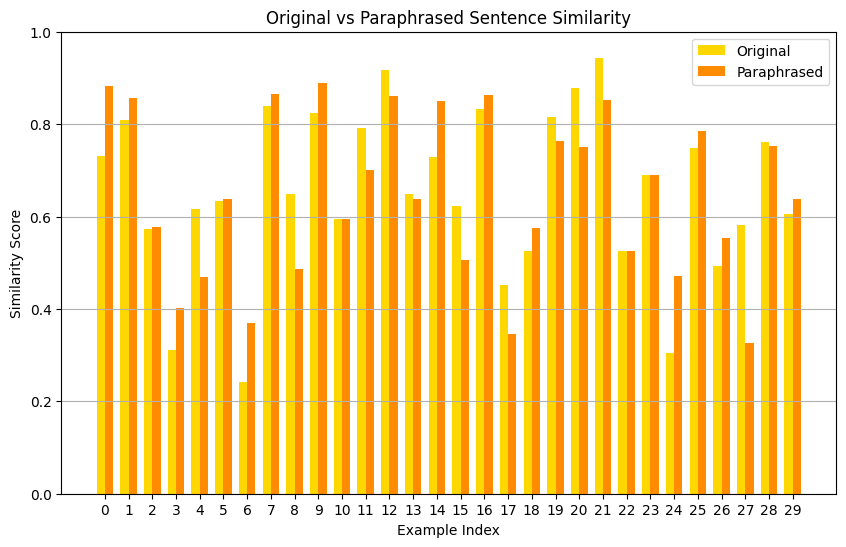

In [38]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(df_sample))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, df_sample['similarity_original'], width, label='Original', color='gold')
plt.bar(x + width/2, df_sample['similarity_paraphrased'], width, label='Paraphrased', color='darkorange')

plt.xlabel('Example Index')
plt.ylabel('Similarity Score')
plt.title('Original vs Paraphrased Sentence Similarity')
plt.xticks(x)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')

plt.show()


We make a scatter plot to compare them

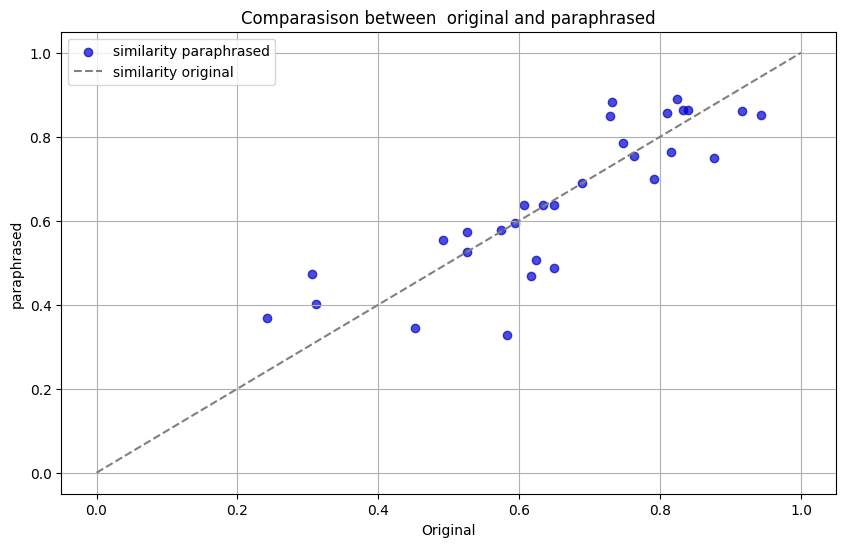

In [42]:
import matplotlib.pyplot as plt

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(
    df_sample['similarity_original'],
    df_sample['similarity_paraphrased'],
    color='mediumblue',
    alpha=0.7,
    label='similarity paraphrased'
)

# Línea diagonal de referencia (igualdad perfecta)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='similarity original')

# Etiquetas y título
plt.xlabel('Original')
plt.ylabel('paraphrased')
plt.title('Comparasison between  original and paraphrased')
plt.legend()
plt.grid(True)

# Mostrar
plt.show()

Now im going to make a bar chart to the compare my Transformers similitude with the Spacy ones

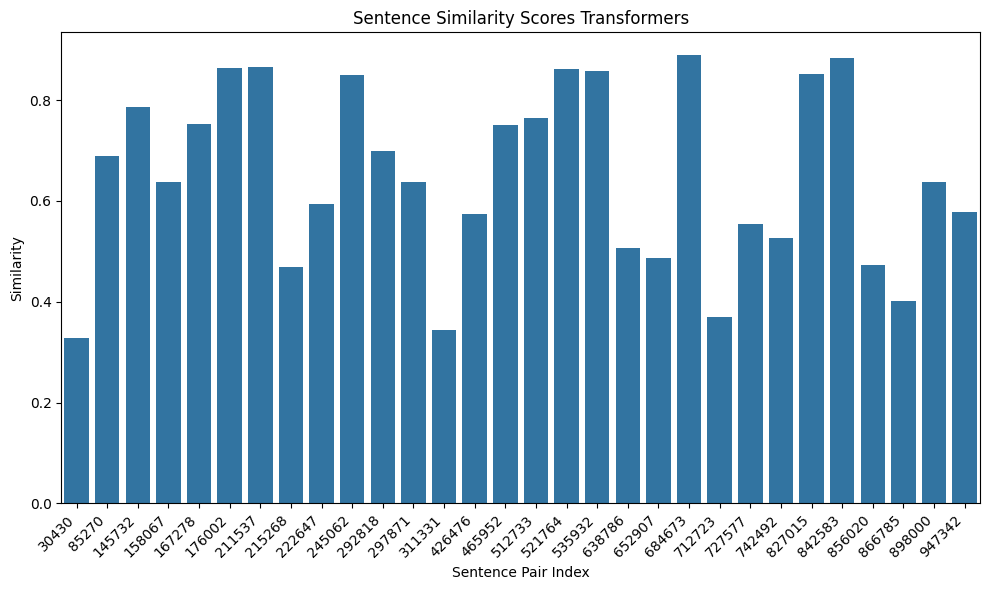

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=df_sample.index, y='similarity_paraphrased', data=df_sample)
plt.xlabel("Sentence Pair Index")
plt.ylabel("Similarity")
plt.title("Sentence Similarity Scores Transformers")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Now we have the similitude between the phrases with a tranformer, we are going to work with teh Spacy library to compare

In [18]:
!pip install spacy
!python -m spacy download es_core_news_md
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 10.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 21.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


This code uses spaCy's en_core_web_md model to calculate semantic similarity between English sentence pairs based on GloVe word embeddings.

In [21]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_md")

def calcular_similitud(row):
    doc1 = nlp(str(row['sentence1_en']))
    doc2 = nlp(str(row['sentence2_en']))
    return doc1.similarity(doc2)

df_sample['similarity_spacy_en'] = df_sample.apply(calcular_similitud, axis=1)

print(df_sample[['sentence1_en', 'sentence2_en', 'similarity_spacy_en']].head(10))

                                             sentence1_en  \
842583  A boy and a white dog run through the grassy f...   
535932  [FAILED TRANSLATION] boston bombing suspect bu...   
947342           Syria agrees to deliver chemical weapons   
866785  You just have to base your answer to the fact ...   
215268     A skateboarder is doing magic on a stone wall.   
297871  The new donations have brought the total amoun...   
712723  I think it is still possible to store seeds un...   
211537  Two hikers are on the summit of a snow -covere...   
652907                       A woman is cutting potatoes.   
684673               Two brown dogs continue in the snow.   

                                             sentence2_en  similarity_spacy_en  
842583               A boy and a dog running on the grass             0.923324  
535932  The suspect of a boston bomb buried in the Vir...             0.825559  
947342  Cameron: Syria and Russia must show that the p...             0.816504  
8667

We make the bar chart just to compare it with the previous one

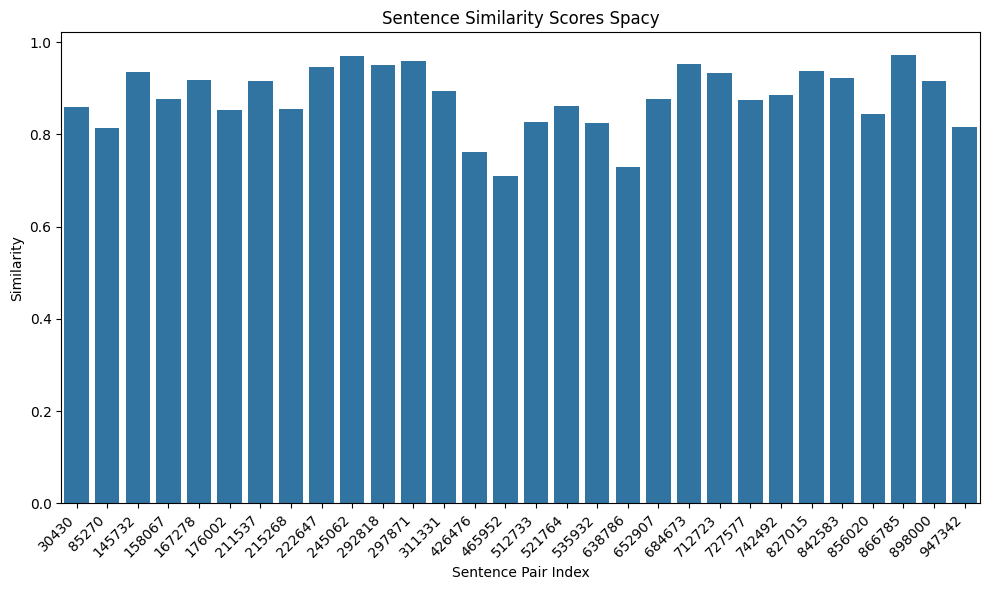

In [43]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=df_sample.index, y='similarity_spacy_en', data=df_sample)
plt.xlabel("Sentence Pair Index")
plt.ylabel("Similarity")
plt.title("Sentence Similarity Scores Spacy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



I want to see how much of the sentences my model say to be similar so I say that if similarity is more than 0.8, they are similar, if not, they arent

In [24]:
df_sample['label'] = (df_sample['similarity_paraphrased'] >= 0.8).astype(int)

In [25]:
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report


In [26]:
threshold = 0.7 # Puedes probar con 0.5, 0.6, 0.8, etc.
df_sample['predicted'] = (df_sample['similarity_paraphrased'] >= threshold).astype(int)


In [48]:
# Accuracy
accuracy = accuracy_score(df_sample['label'], df_sample['predicted'])

# MSE
mse = mean_squared_error(df_sample['label'], df_sample['similarity_paraphrased'])

# confusion matrix
cm = confusion_matrix(df_sample['label'], df_sample['predicted'])


report = classification_report(df_sample['label'], df_sample['predicted'])

print(" Accuracy:", round(accuracy, 4))
print(" MSE:", round(mse, 4))
print("\n confussion matrix:\n", cm)
print("\n Report:\n", report)

✅ Accuracy: 0.8667
📉 MSE: 0.2574

📊 confussion matrix:
 [[18  4]
 [ 0  8]]

📋 Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        22
           1       0.67      1.00      0.80         8

    accuracy                           0.87        30
   macro avg       0.83      0.91      0.85        30
weighted avg       0.91      0.87      0.87        30



Finally, I am going to compare my model (transformers model) with the score on the original dataset to see the performance of my score.

For that, first I need to normalise the score since it goes from 0-5 and I want it fro 0-1 to compare it with my similarity

In [45]:
df_sample['score_normalized'] = df_sample['score'] / 5

Now I already have this, I am going to make a correlation matrix to see how my model performances

In [46]:
correlation = df_sample[['score_normalized', 'similarity_original']].corr()
print(correlation)

                     score_normalized  similarity_original
score_normalized              1.00000              0.73585
similarity_original           0.73585              1.00000


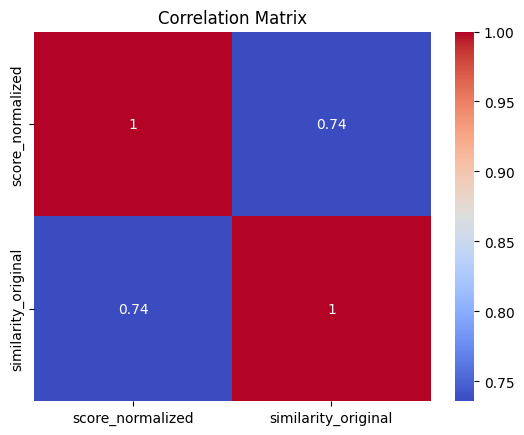

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()